In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as scc
import pandas as pd
import math
import scipy 

In [ ]:
# Define Physics Constants
k = scc.k
e = scc.e
me = scc.m_e
pi = scc.pi
eVJ = scc.eV
eps = scc.epsilon_0
print(k,e,me,pi,eVJ,eps)

In [ ]:
T_e0 = 3000. 
n_e0 = 1e15
Pressure = 10. 
Temperature = 300. 
e_EXC_TH = 11.5
e_ION_TH = 15.8

Ndens = Pressure/k/Temperature
omega_pe0 = pow(n_e0*e*e/eps/me, 0.5)
kTe0 = k*T_e0/eVJ
v_te0 = (k*T_e0/me)**0.5
sigma0 = n_e0*v_te0/omega_pe0
print(Ndens,omega_pe0,v_te0,kTe0,sigma0)

In [ ]:
Ndens_ = Ndens/n_e0
Te_ = 1
me_ = 1
dt_ = 0.1

In [ ]:
def sample_boltez_distr(R1,R2,m=me_,Tr=Te_,Cm=0):
    # Ci = Cm + (2*k*Tr/m)**0.5*np.sin(R1*2*pi)*(-np.log(R2))**0.5
    Ci_ = (2*Tr/me_)**0.5*np.sin(R1*2*pi)*(-np.log(R2))**0.5
    return Ci_
def energy(c,m=me_):
    return 0.5*m*c*c
def boltez_distr(c):
    beta = (me/2/k/T_e0)**0.5
    # print("Cm =", 1/beta)
    c2 = c*c
    # fc = 4/sqrt_pi*beta**3*c2*np.exp(-beta*beta*c2)
    fc_ = (2/pi)**0.5*c2*np.exp(-0.5*c2)
    return fc_
def find_cmax(em):
    em_ = em/kTe0
    cm_ = (em_*2)**0.5
    return cm_
def ndv_to_e(v_,printmode=False):
    # from v_ to e 
    e_ = 0.5*1*v_*v_
    e0 = e_*kTe0
    if printmode:
        print("E_max=",np.max(e0))
    return e0
def fabs(x):
    return np.fabs(x)
def sqrt(x):
    return x**0.5

In [ ]:
# simga_tot
f_qELA = lambda en: 1e-20*(fabs(6.0 / pow(1.0 + (en/0.1) + pow(en/0.6,2.0), 3.3)- 1.1 * pow(en, 1.4) / (1.0 + pow(en/15.0, 1.2)) / sqrt(1.0 + pow(en/5.5, 2.5) + pow(en/60.0, 4.1))) + 0.05 / pow(1.0 + en/10.0, 2.0) + 0.01 * pow(en, 3.0) / (1.0 + pow(en/12.0, 6.0)))

qEXC = lambda en: 1e-20*(0.034 * pow(en-11.5, 1.1) * (1.0 + pow(en/15.0, 2.8)) / (1.0 + pow(en/23.0, 5.5)) + 0.023 * (en-11.5) / pow(1.0 + en/80.0, 1.9)) if en>e_EXC_TH else 0.

qION = lambda en: 1e-20*(970.0 * (en-15.8) / pow(70.0 + en, 2.0) + 0.06 * pow(en-15.8, 2.0) * np.exp(-en/9)) if en > e_ION_TH else 0.

f_qEXC = np.vectorize(qEXC)
f_qION = np.vectorize(qION)
en = np.array([0,11.5,16])
print(qEXC(16))
f_qEXC(en)

In [ ]:
e_max = 50
cm_ = find_cmax(e_max)
print("Vte =", v_te0)
c_ = np.arange(0,cm_+0.01,0.01)
fc_=boltez_distr(c_)
plt.plot(c_,boltez_distr(c_))
plt.vlines(sqrt(2),0.01,0.6,colors = "k", linestyles = "dashed", linewidth=0.7)

In [ ]:
e = ndv_to_e(c_)
sigma_ela = f_qELA(e)
sigma_exc = f_qEXC(e)
sigma_ion = f_qION(e)
sigma_tot = np.zeros(sigma_ela.shape)
sigma = [sigma_ela, sigma_exc, sigma_ion]
for si in sigma:
    sigma_tot += si
sigma_tot *= sigma0
plt.plot(c_,sigma_tot)

In [ ]:
def find_sigma_tot(e):
    sigma_ela = f_qELA(e)
    sigma_exc = f_qEXC(e)
    sigma_ion = f_qION(e)
    sigma_tot = np.zeros(sigma_ela.shape)
    sigma = [sigma_ela, sigma_exc, sigma_ion]
    for si in sigma:
        sigma_tot += si
    sigma_tot *= sigma0
    return sigma_tot

e_max = 50
cm_ = find_cmax(e_max)
print("Vte =", v_te0)
c_ = np.arange(0,cm_+0.01,0.01)
fc_=boltez_distr(c_)
e = ndv_to_e(c_)
sigma_tot = find_sigma_tot(e)

i = 0
size = fc_.shape[0]
dc_ = 0.01
integer = 0
nu = fc_*sigma_tot*c_*Ndens_

while i < size-1:
    c_half = 0.5*(c_[i]+c_[i+1])
    en_half = ndv_to_e(c_half)
    sigma_half = find_sigma_tot(en_half)
    nu_half = boltez_distr(c_half)*sigma_half*c_half*Ndens_
    s1 = (1/6*nu[i]+4/6*nu_half+1/6*nu[i+1])*dc_
    # fc_05 = boltez_distr(0.5*(c_[i]+c_[i+1]))
    # s1 = (1/6*fc_[i]+4/6*fc_05+1/6*fc_[i+1])*dc_
    integer += s1
    i += 1
print("Non-Dimension Collision Frequency IN THIS CASE is",integer)
cfq1_ = integer

In [ ]:
def random_sample(c_,fmax,mode="ar"):
# acceptance and reject
    if mode == "ar":
        while True:
            R1 = np.random.rand()
            c = 0 + R1*(c_[-1]-c_[0])
            fc = boltez_distr(c)
            R2 = np.random.rand()
            if R2 < fc/fmax:
                break
    elif mode == "m":
        n = c_.shape[0]
        sq2 = sqrt(2)
        
        R1 = np.random.rand(3*n)
        R2 = np.random.rand(3*n)
        vel = sq2*np.sin(2*pi*R1)*(-np.log(R2))**0.5
        vx, vy, vz = vel[0:n-1], vel[n:2*n-1], vel[2*n:3*n-1]
        c = (vx*vx+vy*vy+vz*vz)**0.5
    return c

def find_sigma_tot(e):
    sigma_ela = f_qELA(e)
    sigma_exc = f_qEXC(e)
    sigma_ion = f_qION(e)
    sigma_tot = np.zeros(sigma_ela.shape)
    sigma = [sigma_ela, sigma_exc, sigma_ion]
    for si in sigma:
        sigma_tot += si
    sigma_tot *= sigma0
    return sigma_tot

In [ ]:
pc_=random_sample(np.zeros(10000),1,"m")

In [ ]:
N = 10000
sample = []
fmax = np.max(boltez_distr(c_))
for i in range(N):
    sample.append(random_sample(c_,fmax))
pc_ = np.array(sample)

print(np.mean(pc_), sqrt(2/pi)*2)
fmax

In [ ]:
import pandas as pd
dataframe = pd.DataFrame(pc_,columns=['c'])

fig = plt.figure(figsize = (10,6))
ax1 = fig.add_subplot(2,1,1) 
ax1.scatter(dataframe.index, dataframe.values)
plt.plot(range(N),np.ones(N)*sqrt(2),'r')
plt.grid()

ax2 = fig.add_subplot(2,1,2) 
dataframe.hist(bins=30,alpha = 0.5,ax = ax2)
dataframe.plot(kind = 'kde', secondary_y=True,ax = ax2)
plt.grid()

In [ ]:
print(1/cfq1_)

In [ ]:
def effective_collisions(P_cs):
    nparts = P_cs.shape[0]
    effective_collisions = 0
    for i in range(nparts):
        R = np.random.rand()
        if R < P_cs[i]/P_cmax:
            effective_collisions += 1
    return effective_collisions

In [ ]:
N = 10000
pc_=random_sample(np.zeros(N),1,"m")
pen = ndv_to_e(pc_)
psigma = find_sigma_tot(pen)
nu = psigma*pc_*Ndens_
nu_max = np.max(nu)

# find null_collision part in total collision
P_cmax = 1 - np.exp(-nu_max*dt_)
n_selected = int(N * P_cmax)
pc_s = np.random.choice(pc_,n_selected,replace=False)
pen_s = ndv_to_e(pc_s)
psigma_s = find_sigma_tot(pen_s)
nu_s = psigma_s*pc_s*Ndens_
P_cs = 1 - np.exp(-nu_s*dt_)

collection = []
ave = 1/(dt_*N)
ind = np.arange(2000)
for i in ind:
    eff_c = effective_collisions(P_cs)
    collection.append(eff_c*ave)
collection = np.array(collection)
fqINTE = (ind*0+1)*cfq1_
avefreq = (ind*0+1)*np.mean(collection)
plt.scatter(ind,collection,marker='o')
plt.plot(ind,fqINTE,linewidth=2.5,color='r')
plt.plot(ind,avefreq,color='k',linewidth=2.5)
plt.show()


In [ ]:
def find_collision(nu):
    npart = nu.shape[0]
    count_collisions = 0
    Pc = 1 - np.exp(-nu*dt_)
    R = np.random.rand(npart)
    for i in range(npart):
        if R[i] < Pc[i]:
            count_collisions += 1
    return count_collisions

# find_collision = np.vectorize(find_collision)

In [ ]:
store = []

In [ ]:
N = 10000
nsamp = 30
dt_ = 0.1
integer_coll_freq = 0.002744762867676734
collection = []
for ns in range(nsamp): 
    pc_=random_sample(np.zeros(N),1,"m")
    pen = ndv_to_e(pc_)
    psigma_ = find_sigma_tot(pen)
    nu_ = psigma_*pc_*Ndens_
    coll_count = find_collision(nu_)
    collection.append(coll_count)
coll_counts = np.array(collection)
unit_coll_freq = coll_counts/N/dt_
average_coll_freq = np.mean(unit_coll_freq)
store.append(average_coll_freq)
nsamp_list = np.arange(nsamp)
plt.scatter(nsamp_list, unit_coll_freq)
plt.plot(nsamp_list, average_coll_freq*np.ones(nsamp),color='k',linewidth=2.5)
plt.plot(nsamp_list, integer_coll_freq*np.ones(nsamp),color='r',linewidth=2.5)
plt.show()

In [ ]:
def effective_collisions(P_cs):
    nparts = P_cs.shape[0]
    effective_collisions = 0
    for i in range(nparts):
        R = np.random.rand()
        if R < P_cs[i]/P_cmax:
            effective_collisions += 1
    return effective_collisions

In [ ]:
collision_frequency = []
init_temp = []
def effective_collisions(P_sc, P_cmax):
    nparts = P_sc.shape[0]
    effective_collisions = 0
    for i in range(nparts):
        R = np.random.rand()
        if R < P_sc[i]/P_cmax:
            effective_collisions += 1
    return effective_collisions

def random_sample(c_,fmax):
# acceptance and reject
    while True:
        R1 = np.random.rand()
        c = 0 + R1*(c_[-1]-c_[0])
        fc = boltez_distr(c)
        R2 = np.random.rand()
        if R2 < fc/fmax:
            break
    return c

def find_sigma_tot(e):
    sigma_ela = f_qELA(e)
    sigma_exc = f_qEXC(e)
    sigma_ion = f_qION(e)
    sigma_tot = np.zeros(sigma_ela.shape)
    sigma = [sigma_ela, sigma_exc, sigma_ion]
    for si in sigma:
        sigma_tot += si
    sigma_tot *= sigma0
    return sigma_tot


In [ ]:
cfq = np.array(collision_frequency)
itemp = np.array(init_temp)
size = len(init_temp)
x = range(size)
fig = plt.figure(figsize = (10,6))
ax1 = fig.add_subplot(2,1,1) 
ax1.scatter(x,itemp,marker='+',color='k')
ax1.plot(x,np.ones(size),linewidth = 2.5, color = "g")
# ax1.set_xlabel('N')
ax1.set_ylabel(r'$\tilde{T}_e$')
plt.grid()

ax2 = fig.add_subplot(2,1,2)
ax2.scatter(x,cfq,color='b')
ax2.plot(x,np.ones(size)*cfq1_,linewidth = 2.5, color = "r")
ax2.set_ylabel(r'$\tilde{\nu}_e$')
plt.grid()
plt.tight_layout()

In [ ]:
collision_frequency = []
init_temp = []

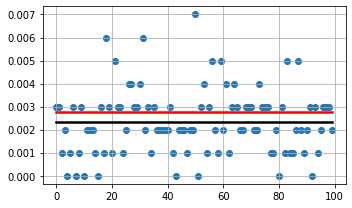

In [404]:
N = 10000
sample = []

fmax = np.max(boltez_distr(c_))
# for i in range(N):
    # sample.append(random_sample(c_,fmax,'m'))
pc_ = random_sample(c_,fmax,'m')
pen = ndv_to_e(pc_)
psigma_ = find_sigma_tot(pen)
nu = psigma_*pc_*Ndens_
nu_max = np.max(nu)

# find sample temperature 
pke_ = pc_**2*0.5
mean_ke = np.mean(pke_)
temp_sample = mean_ke/1.5
init_temp.append(temp_sample)

# find max_collision part in total collision
P_cmax = 1 - np.exp(-nu_max*dt_)
n_selected = int(N * P_cmax)
pc_s = np.random.choice(pc_,n_selected,replace=False)
pen_s = ndv_to_e(pc_s)
psigma_s = find_sigma_tot(pen_s)
nu_s = psigma_s*pc_s*Ndens_
P_cs = 1 - np.exp(-nu_s*dt_)

# Clarify collision to effective and null
collection = []
num_sample = 100
ave = 1/(dt_*N)
ind = np.arange(num_sample)
one = np.ones(num_sample)
for i in ind:
    eff_c = effective_collisions(P_cs,P_cmax)
    collection.append(eff_c*ave)
collection = np.array(collection)
fqINTE = (ind*0+1)*cfq1_
average_collision_frequency = np.mean(collection)
average_collision_frequency = np.ones(num_sample)*np.mean(collection)
collision_frequency.append(average_collision_frequency[0])

df = pd.DataFrame(collection,columns=['nu'])
fig,ax = plt.subplots(figsize = (5,3))
# # ax1 = fig.add_subplot(2,1,1) 
ax.scatter(df.index, df.values)
ax.plot(ind,fqINTE,color='r',linewidth=2.5)
ax.plot(ind,average_collision_frequency,color='k',linewidth=2.5)
plt.grid()

img_name = "Fig/Inte_vs.Particle{}".format(id)

plt.tight_layout()
plt.savefig(img_name+'.png',dpi=300)
plt.show()

In [356]:
print(len(collision_frequency),len(init_temp))

43 44


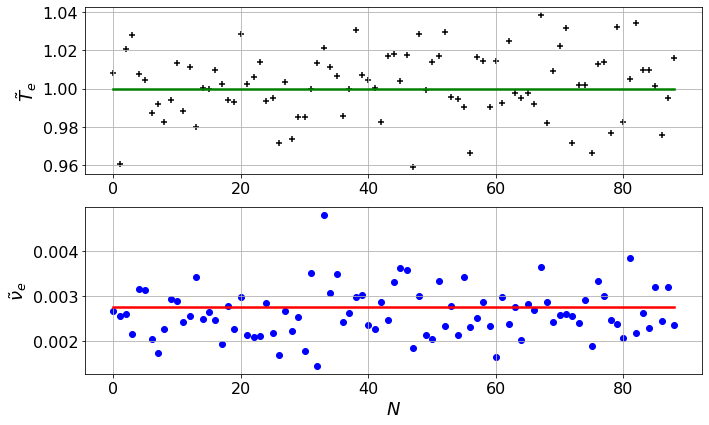

In [408]:
cfq = np.array(collision_frequency)
itemp = np.array(init_temp[1:])
size = len(collision_frequency)
x = range(size)
fig = plt.figure(figsize = (10,6))
ax1 = fig.add_subplot(2,1,1) 
ax1.scatter(x,itemp,marker='+',color='k')
ax1.plot(x,np.ones(size),linewidth = 2.5, color = "g")
ax1.set_ylabel(r"$\tilde{T}_{e}$", fontsize=18)
ax1.tick_params(labelsize=16)
plt.grid()

ax2 = fig.add_subplot(2,1,2)
ax2.scatter(x,cfq,color='b')
ax2.plot(x,np.ones(size)*cfq1_,linewidth = 2.5, color = "r")
ax2.set_ylabel(r'$\tilde{\nu}_e$',fontsize=18)
ax2.set_xlabel(r"$N$", fontsize=18)
ax2.tick_params(labelsize=16)
plt.grid()
plt.tight_layout()
img_name = "Fig/null_collision_method"
plt.savefig(img_name+".png",dpi=300)